In [1]:
from online_gp.datasets.regression import *
from online_gp.models import OnlineExactRegression, OnlineSKIRegression
from online_gp.models.stems import LinearStem, Identity

import numpy as np
import pandas as pd
import torch

import time

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.25)

In [2]:
datasets = Skillcraft()

In [3]:
train_x, train_y = datasets.train_dataset[:]
test_x, test_y = datasets.test_dataset[:]

In [4]:
feature_dim = 2
stem_lr = 1e-2
gp_lr = 1e-2
grid_bound = 1
grid_size = 24

stem = LinearStem(train_x.size(-1), feature_dim)
# stem = Identity(train_x.size(-1))
# regression = OnlineExactRegression(stem, train_x, train_y, stem_lr, gp_lr)
batch_model = OnlineSKIRegression(stem, train_x, train_y, gp_lr, grid_size, grid_bound)
if torch.cuda.is_available():
    batch_model = batch_model.cuda()
    
train_metrics = batch_model.fit(train_x, train_y, 100, datasets.test_dataset)

/home/sam/Code/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


final test RMSE: 0.7165


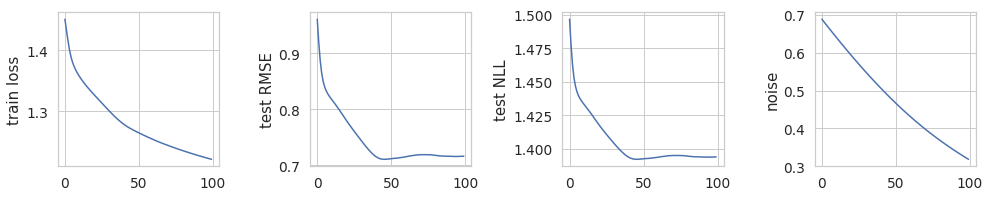

In [5]:
train_df = pd.DataFrame(train_metrics)

print(f'final test RMSE: {train_df.test_rmse.values[-1]:0.4f}')

fig = plt.figure(figsize=(14, 3))

ax = fig.add_subplot(1, 4, 1)
ax.plot(train_df.train_loss)
ax.set_ylabel('train loss')

ax = fig.add_subplot(1, 4, 2)
ax.plot(train_df.test_rmse)
ax.set_ylabel('test RMSE')

ax = fig.add_subplot(1, 4, 3)
ax.plot(train_df.test_nll)
ax.set_ylabel('test NLL')

ax = fig.add_subplot(1, 4, 4)
ax.plot(train_df.noise)
ax.set_ylabel('noise')

plt.tight_layout()

In [6]:
def get_grid(grid_bound, grid_dim, grid_size=50):
    grid_vals = [np.linspace(-grid_bound, grid_bound, num=grid_size)] * grid_dim
    grid_mesh = np.meshgrid(*grid_vals)
    grid_tensor = torch.tensor([vals.reshape(-1) for vals in grid_mesh]).float().t()
    if torch.cuda.is_available():
        grid_tensor = grid_tensor.cuda()
    return grid_mesh, grid_tensor

def draw_contour(model, test_x, test_y, grid_bound, grid_size, num_test):
    grid_mesh, grid_x = get_grid(grid_bound, 2, grid_size)
    with torch.no_grad():
        grid_pred = model.gp(grid_x)
        features = model.stem(test_x[:num_test])
        test_y = test_y[:num_test]

    all_y = torch.cat([grid_pred.mean, test_y.squeeze(-1)]).cpu().numpy()
    vmin, vmax = all_y.min(), all_y.max()

    grid_mean = grid_pred.mean.view(grid_size, grid_size).cpu()


    fig = plt.figure(figsize=(6, 4))

    ax = fig.add_subplot(1, 1, 1)
    f = ax.contour(*grid_mesh, grid_mean, vmin=vmin, vmax=vmax, linewidths=2)

    x, y = features[:, 0].cpu(), features[:, -1].cpu()
    colors = test_y.squeeze(-1).cpu()
    ax.scatter(x, y, c=colors, vmin=vmin, vmax=vmax, s=64)

    ax.set_xlabel('$h_1$')
    ax.set_ylabel('$h_2$')
    fig.colorbar(f, ax=ax)

    plt.tight_layout()
    return fig

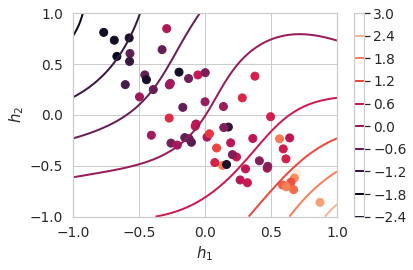

In [7]:
grid_size = 50
num_test = 64
_ = draw_contour(batch_model, test_x, test_y, grid_bound, grid_size, num_test)

In [8]:
num_init = 1024
train_x, train_y = datasets.train_dataset[:]
init_x, train_x = train_x[:num_init], train_x[num_init:]
init_y, train_y = train_y[:num_init], train_y[num_init:]

feature_dim = 2
stem_lr = 1e-2
gp_lr = 1e-2
grid_bound = 1
grid_size = 24

stem = LinearStem(train_x.size(-1), feature_dim)
online_model = OnlineSKIRegression(stem, init_x, init_y, gp_lr, grid_size, grid_bound)
if torch.cuda.is_available():
    online_model = online_model.cuda()
    
pretrain_metrics = online_model.fit(init_x, init_y, 100, datasets.test_dataset)

final test RMSE: 0.7321


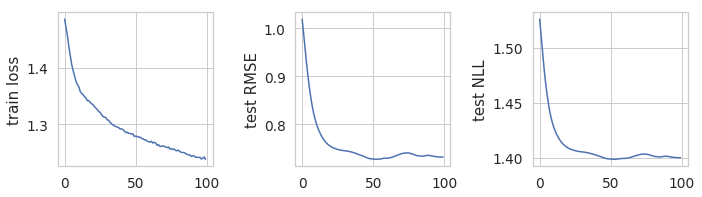

In [9]:
train_df = pd.DataFrame(pretrain_metrics)

print(f'final test RMSE: {train_df.test_rmse.values[-1]:0.4f}')

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 3, 1)
ax.plot(train_df.train_loss)
ax.set_ylabel('train loss')

ax = fig.add_subplot(1, 3, 2)
ax.plot(train_df.test_rmse)
ax.set_ylabel('test RMSE')

ax = fig.add_subplot(1, 3, 3)
ax.plot(train_df.test_nll)
ax.set_ylabel('test NLL')

plt.tight_layout()

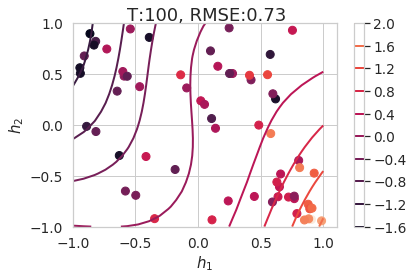

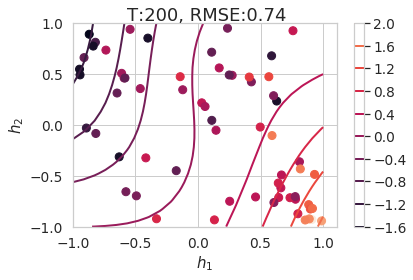

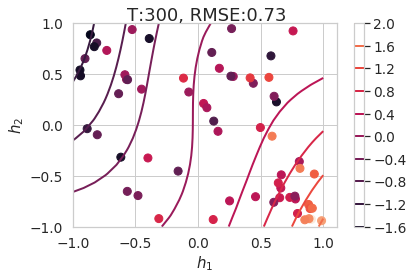

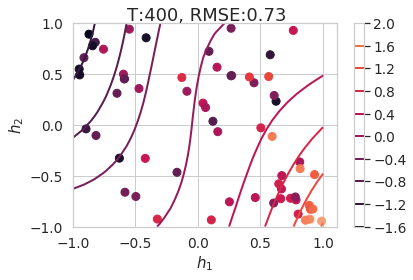

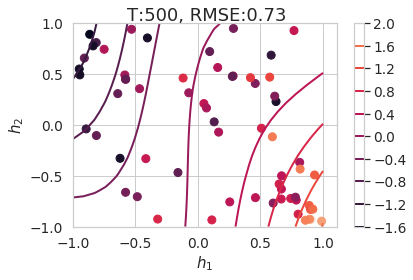

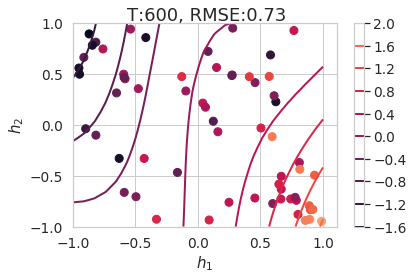

KeyboardInterrupt: 

In [10]:
online_model.set_lr(gp_lr=1e-3, stem_lr=1e-4)
logging_freq = 100
online_rmse = online_nll = 0
batch_rmse = batch_nll = 0

records = []
for t, (x, y) in enumerate(zip(train_x, train_y)):
    start_clock = time.time()
    o_rmse, o_nll = online_model.evaluate(x, y)
    stem_loss, gp_loss = online_model.update(x, y)
    step_time = time.time() - start_clock

    b_rmse, b_nll = batch_model.evaluate(x, y)
    online_rmse += o_rmse
    online_nll += o_nll
    batch_rmse += b_rmse
    batch_nll += b_nll

    regret = online_rmse - batch_rmse

    if t % logging_freq == (logging_freq - 1):
        rmse, nll = online_model.evaluate(test_x, test_y)
        fig = draw_contour(online_model, test_x, test_y, grid_bound, grid_size, num_test)
        fig.suptitle(f'T:{t + 1}, RMSE:{rmse:0.2f}')
        plt.show(fig)
        records.append(dict(
                stem_loss=stem_loss,
                gp_loss=gp_loss,
                batch_rmse=batch_rmse,
                batch_nll=batch_nll,
                online_rmse=online_rmse,
                online_nll=online_nll,
                regret=regret,
                test_rmse=rmse,
                test_nll=nll,
                step_time=step_time
            ))
logging_freq = 100
online_rmse = online_nll = 0
batch_rmse = batch_nll = 0

records = []
for t, (x, y) in enumerate(zip(train_x, train_y)):
    start_clock = time.time()
    o_rmse, o_nll = online_model.evaluate(x, y)
    stem_loss, gp_loss = online_model.update(x, y)
    step_time = time.time() - start_clock

    b_rmse, b_nll = batch_model.evaluate(x, y)
    online_rmse += o_rmse
    online_nll += o_nll
    batch_rmse += b_rmse
    batch_nll += b_nll

    regret = online_rmse - batch_rmse

    if t % logging_freq == (logging_freq - 1):
        rmse, nll = online_model.evaluate(test_x, test_y)
        fig = draw_contour(online_model, test_x, test_y, grid_bound, grid_size, num_test)
        fig.suptitle(f'T:{t + 1}, RMSE:{rmse:0.2f}')
        plt.show(fig)
        records.append(dict(
                stem_loss=stem_loss,
                gp_loss=gp_loss,
                batch_rmse=batch_rmse,
                batch_nll=batch_nll,
                online_rmse=online_rmse,
                online_nll=online_nll,
                regret=regret,
                test_rmse=rmse,
                test_nll=nll,
                step_time=step_time
            ))
logging_freq = 100
online_rmse = online_nll = 0
batch_rmse = batch_nll = 0

records = []
for t, (x, y) in enumerate(zip(train_x, train_y)):
    start_clock = time.time()
    o_rmse, o_nll = online_model.evaluate(x, y)
    stem_loss, gp_loss = online_model.update(x, y)
    step_time = time.time() - start_clock

    b_rmse, b_nll = batch_model.evaluate(x, y)
    online_rmse += o_rmse
    online_nll += o_nll
    batch_rmse += b_rmse
    batch_nll += b_nll

    regret = online_rmse - batch_rmse

    if t % logging_freq == (logging_freq - 1):
        rmse, nll = online_model.evaluate(test_x, test_y)
        fig = draw_contour(online_model, test_x, test_y, grid_bound, grid_size, num_test)
        fig.suptitle(f'T:{t + 1}, RMSE:{rmse:0.2f}')
        plt.show(fig)
        records.append(dict(
                stem_loss=stem_loss,
                gp_loss=gp_loss,
                batch_rmse=batch_rmse,
                batch_nll=batch_nll,
                online_rmse=online_rmse,
                online_nll=online_nll,
                regret=regret,
                test_rmse=rmse,
                test_nll=nll,
                step_time=step_time
            ))